In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
%matplotlib inline

2.0.0


In [13]:
def plot_series(time, series, format="-", start=0, end=None, **kwargs):
    plt.plot(time[start:end], series[start:end], format, **kwargs)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

In [4]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

In [5]:
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [6]:
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

In [8]:
# Create the series
series = (baseline 
          + trend(time, slope) 
          + seasonality(time, period=365, amplitude=amplitude))
# Update with noise
series += noise(time, noise_level, seed=42)

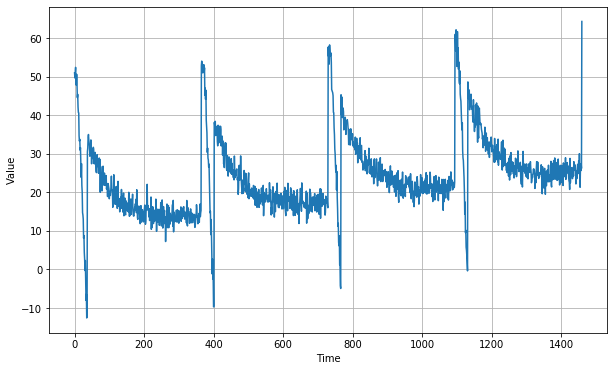

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

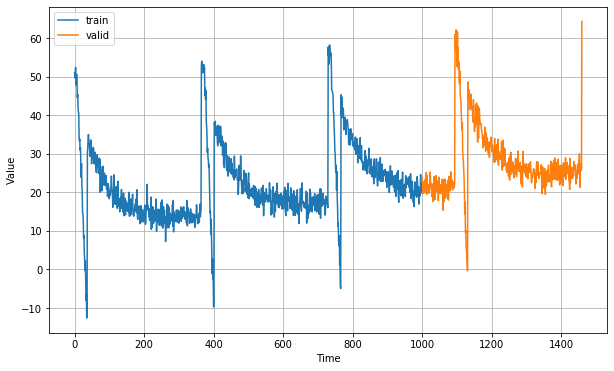

In [14]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, label='train')
plot_series(time_valid, x_valid, label='valid')
plt.legend();

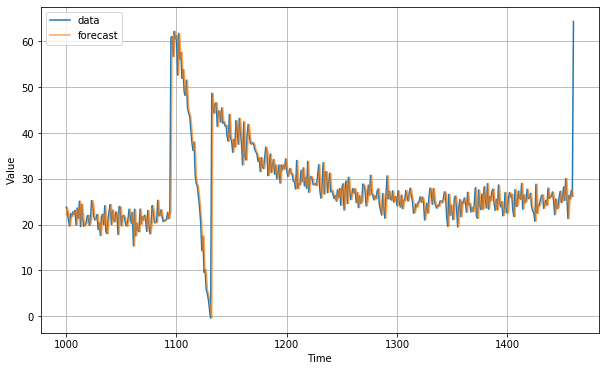

In [15]:
naive_forecast = series[split_time - 1: -1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='data')
plot_series(time_valid, naive_forecast, alpha=0.7, label='forecast')
plt.legend();

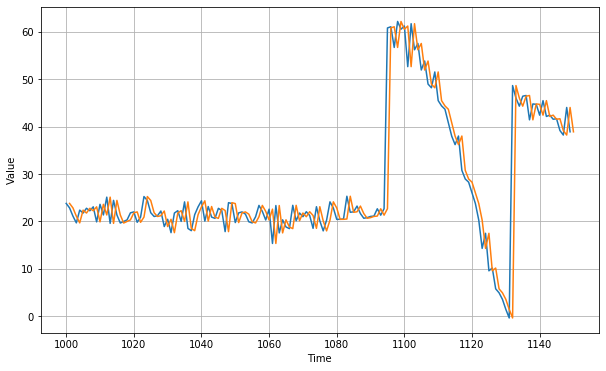

In [16]:
# zoom in
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [17]:
# TF 2.0 only
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

20.158266
2.5868616


In [18]:
def mse(target, actual):
    return ((target - actual) ** 2).mean()

In [19]:
mse(x_valid, naive_forecast)

20.158266

In [20]:
def moving_average_forecast(series, window_size):
    '''Forecasts as the mean of the last few values'''
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

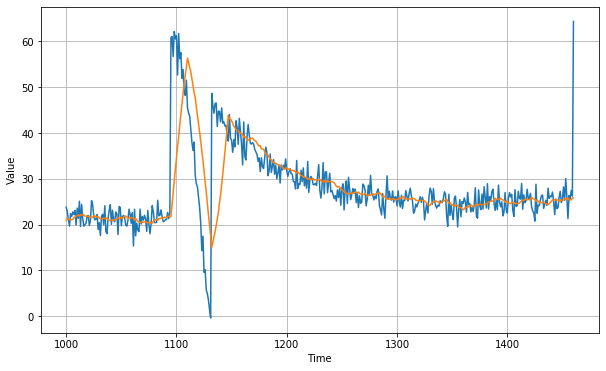

In [24]:
moving_avg = moving_average_forecast(series, 15)[split_time - 15:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [25]:
mse(x_valid, moving_avg) 

50.86414

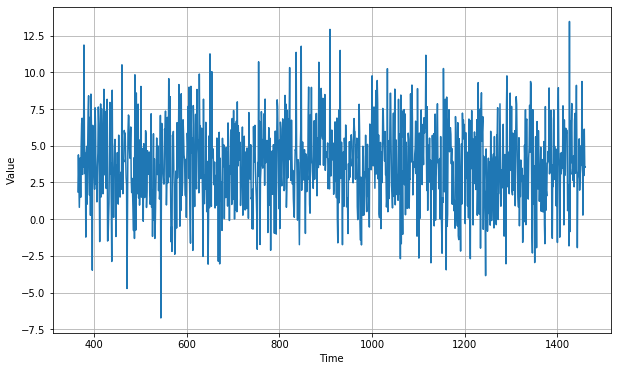

In [26]:
# worse than naive; does not anticipate trend or seasonality.  Add diff
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)

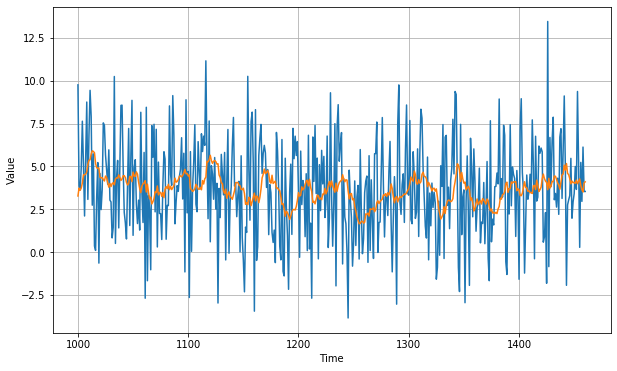

In [34]:
diff_moving_avg = moving_average_forecast(
    diff_series, 15
)[split_time - 365 - 15:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)

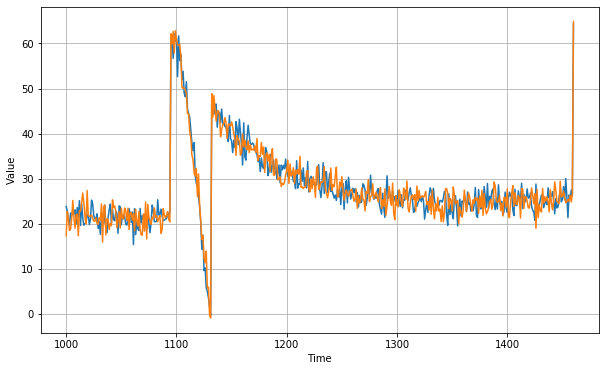

In [35]:
diff_moving_avg_plus_past = (series[split_time - 365:-365] 
                             + diff_moving_avg)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

In [36]:
mse(x_valid, diff_moving_avg_plus_past)

8.949405

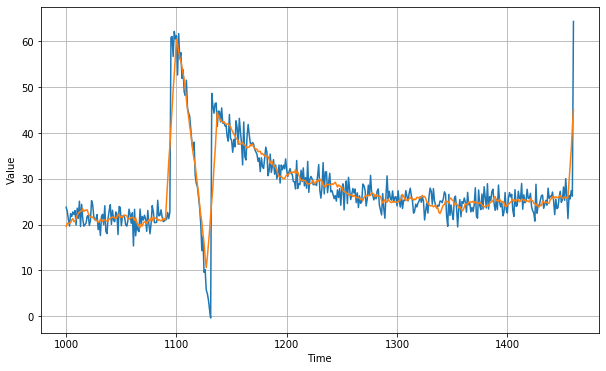

In [37]:
# Best yet, but we can remove noise in preds
diff_ma_plus_smooth_past = (
    moving_average_forecast(series[split_time - 370:-360], 10) 
    + diff_moving_avg)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_ma_plus_smooth_past)

In [38]:
mse(x_valid, diff_ma_plus_smooth_past)

13.751612